# Exploratory Dataset for Delhi AQI

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.feature_selection import mutual_info_regression

In [2]:
sns.set_theme(style="ticks", palette="pastel")

## Import Data

In [3]:
original_dataset = pd.read_csv("./data/delhi_ncr_aqi_dataset.csv") 

## Visualizing DataSet

In [4]:
original_dataset

,datetime,date,year,month,day,hour,day_of_week,is_weekend,season,city,...,no2,so2,co,o3,temperature,humidity,wind_speed,visibility,aqi,aqi_category
0,2020-01-01 06:00:00,2020-01-01,2020,1,1,6,Wednesday,0,winter,Delhi,...,119.6,47.7,5.19,12.3,9.4,100,3.6,1.2,500,Severe
1,2020-01-01 12:00:00,2020-01-01,2020,1,1,12,Wednesday,0,winter,Delhi,...,117.9,39.3,4.32,15.8,20.6,50,5.9,1.4,500,Severe
2,2020-01-01 18:00:00,2020-01-01,2020,1,1,18,Wednesday,0,winter,Delhi,...,150.1,36.3,7.13,14.3,12.4,56,4.5,1.1,500,Severe
3,2020-01-01 23:00:00,2020-01-01,2020,1,1,23,Wednesday,0,winter,Delhi,...,142.0,30.3,4.90,13.2,14.4,48,5.8,1.4,500,Severe
4,2020-01-01 06:00:00,2020-01-01,2020,1,1,6,Wednesday,0,winter,Delhi,...,138.4,41.5,7.56,15.4,6.8,100,2.8,0.4,500,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201659,2025-12-31 23:00:00,2025-12-31,2025,12,31,23,Wednesday,0,winter,Ghaziabad,...,97.0,23.9,5.58,14.8,16.1,51,3.8,0.9,500,Severe
201660,2025-12-31 06:00:00,2025-12-31,2025,12,31,6,Wednesday,0,winter,Ghaziabad,...,119.2,26.9,5.34,12.1,9.8,95,3.2,1.2,500,Severe
201661,2025-12-31 12:00:00,2025-12-31,2025,12,31,12,Wednesday,0,winter,Ghaziabad,...,90.3,33.7,3.73,28.2,21.4,57,7.1,2.9,500,Severe
201662,2025-12-31 18:00:00,2025-12-31,2025,12,31,18,Wednesday,0,winter,Ghaziabad,...,170.7,20.9,6.98,22.9,15.4,51,6.8,1.2,500,Severe


In [5]:
original_dataset.shape

(201664, 25)

In [6]:
original_dataset.columns

Index(['datetime', 'date', 'year', 'month', 'day', 'hour', 'day_of_week',
       'is_weekend', 'season', 'city', 'station', 'latitude', 'longitude',
       'pm25', 'pm10', 'no2', 'so2', 'co', 'o3', 'temperature', 'humidity',
       'wind_speed', 'visibility', 'aqi', 'aqi_category'],
      dtype='str')

## Trimming Down redundant column through initial intuition

In [7]:
trimmed_dataset = original_dataset.drop(columns=["date","year", "month", "day","hour"])

## Trimmed Down Dataset

In [10]:
trimmed_dataset['season'].unique()

<StringArray>
['winter', 'summer', 'monsoon', 'post_monsoon']
Length: 4, dtype: str

In [41]:
trimmed_dataset.shape

(201664, 20)

In [42]:
trimmed_dataset["datetime"] = pd.to_datetime(trimmed_dataset["datetime"])

## AQI on all seasons grouped by week days

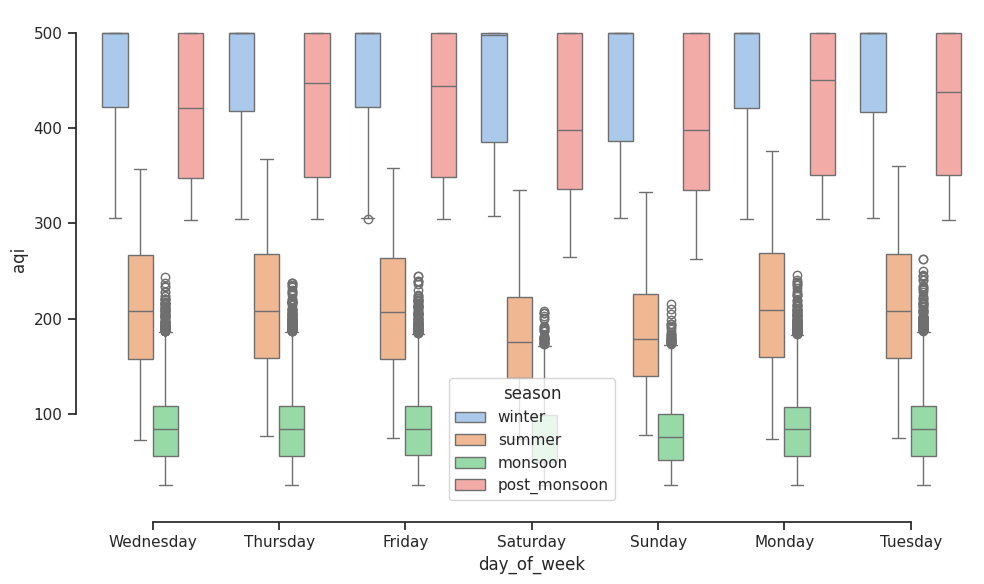

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=trimmed_dataset, y = "aqi", x = "day_of_week", hue="season", ax=ax)
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.show()

## Transforming data set for correlations and ML

In [44]:
columns = trimmed_dataset.columns

In [45]:
print(columns)

Index(['datetime', 'day_of_week', 'is_weekend', 'season', 'city', 'station',
       'latitude', 'longitude', 'pm25', 'pm10', 'no2', 'so2', 'co', 'o3',
       'temperature', 'humidity', 'wind_speed', 'visibility', 'aqi',
       'aqi_category'],
      dtype='str')


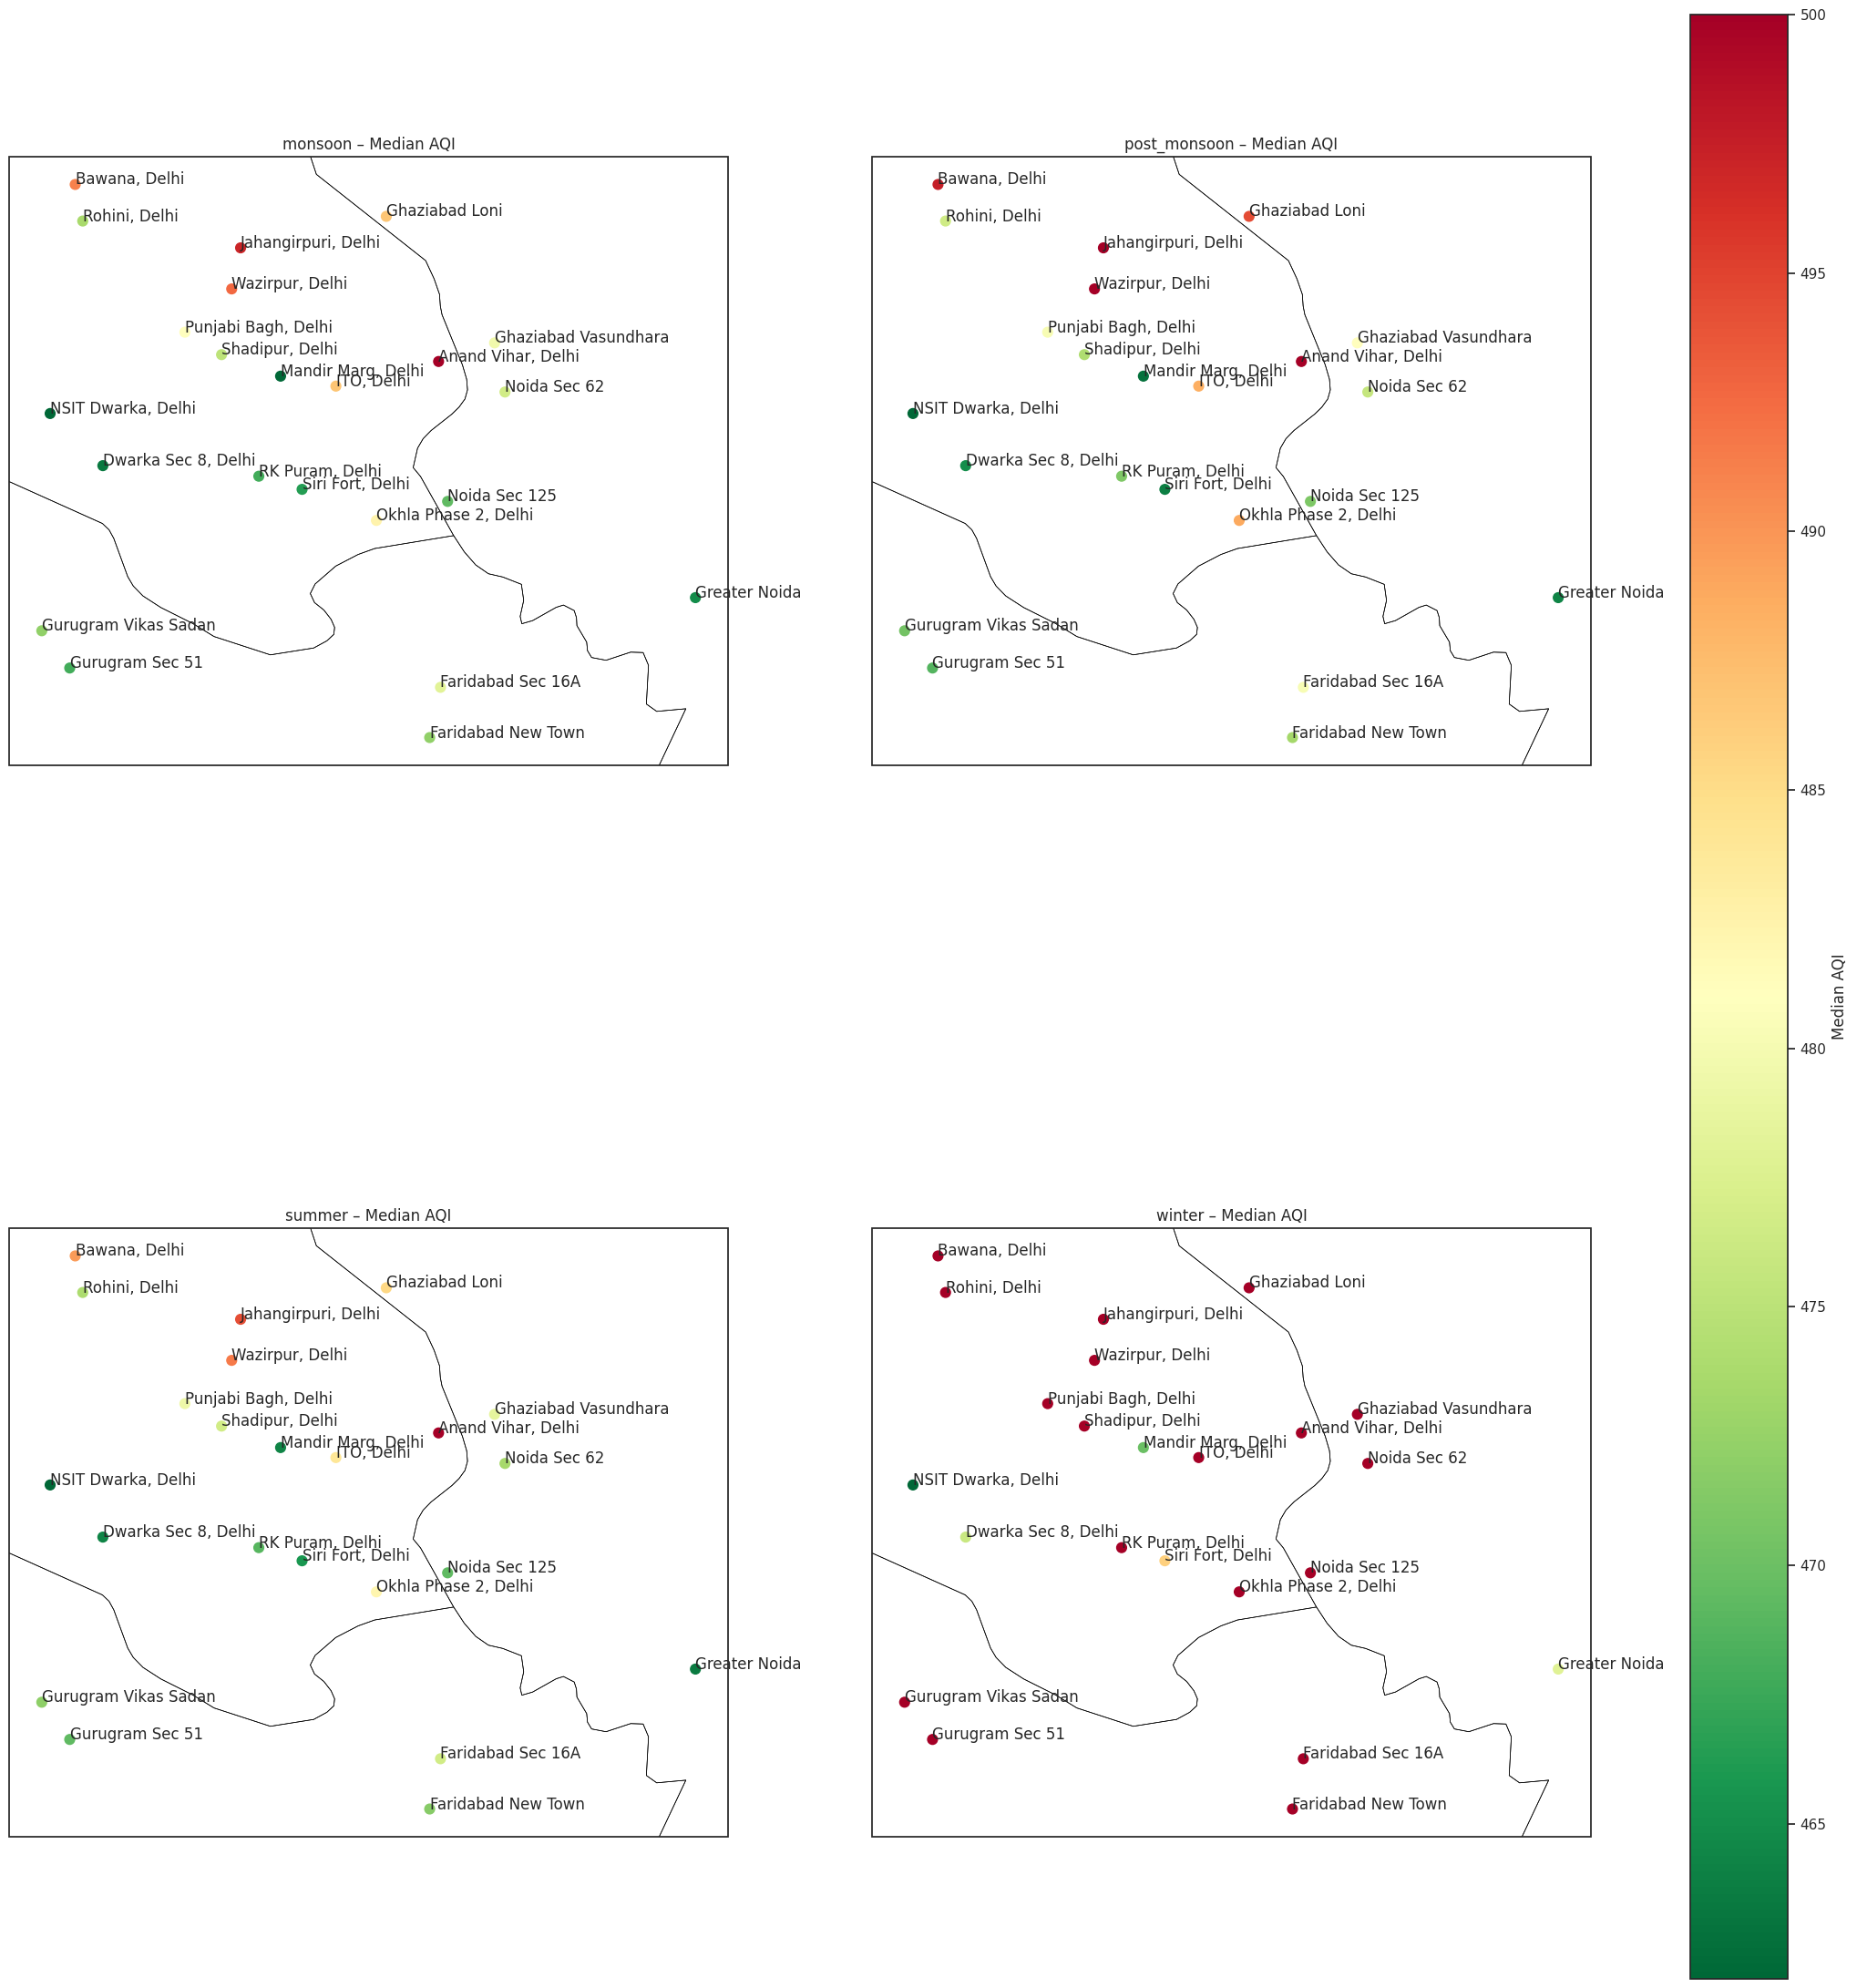

In [46]:
df = trimmed_dataset
seasonal_station_median = (
    df
    .groupby(
        ["season", "station", "latitude", "longitude"],
        as_index=False
    )["aqi"]
    .median()
)
seasons = sorted(seasonal_station_median["season"].unique())
fig = plt.figure(figsize=(28, 28))

for i, season in enumerate(seasons):
    ax = plt.subplot(
    2, 2, i + 1,
    projection=ccrs.PlateCarree()
    )

    sub = seasonal_station_median[
        seasonal_station_median["season"] == season
    ]
    for _, row in sub.iterrows():
        ax.text(
            row["longitude"],
            row["latitude"],
            row["station"],
            fontsize=12,
            transform=ccrs.PlateCarree()
        )
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    sc = ax.scatter(
        sub["longitude"],
        sub["latitude"],
        c=sub["aqi"],
        cmap="RdYlGn_r",
        s=60,
        transform=ccrs.PlateCarree()
    )

    ax.set_title(f"{season} – Median AQI")

fig.colorbar(sc, ax=fig.axes, label="Median AQI")
plt.show()

In [47]:
trimmed_dataset_encoded = pd.get_dummies(data=trimmed_dataset,columns=["day_of_week", "season"],drop_first=True)

In [48]:
trimmed_dataset_encoded = trimmed_dataset_encoded.drop(columns=["city","aqi_category","station"])

In [49]:
columns = trimmed_dataset_encoded.columns

In [50]:
print(columns)

Index(['datetime', 'is_weekend', 'latitude', 'longitude', 'pm25', 'pm10',
       'no2', 'so2', 'co', 'o3', 'temperature', 'humidity', 'wind_speed',
       'visibility', 'aqi', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'season_post_monsoon', 'season_summer',
       'season_winter'],
      dtype='str')


In [51]:
trimmed_dataset_encoded.head()

,datetime,is_weekend,latitude,longitude,pm25,pm10,no2,so2,co,o3,...,aqi,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,season_post_monsoon,season_summer,season_winter
0,2020-01-01 06:00:00,0,28.6469,77.3164,371.8,739.4,119.6,47.7,5.19,12.3,...,500,False,False,False,False,False,True,False,False,True
1,2020-01-01 12:00:00,0,28.6469,77.3164,301.1,588.8,117.9,39.3,4.32,15.8,...,500,False,False,False,False,False,True,False,False,True
2,2020-01-01 18:00:00,0,28.6469,77.3164,334.0,602.6,150.1,36.3,7.13,14.3,...,500,False,False,False,False,False,True,False,False,True
3,2020-01-01 23:00:00,0,28.6469,77.3164,403.8,841.8,142.0,30.3,4.90,13.2,...,500,False,False,False,False,False,True,False,False,True
4,2020-01-01 06:00:00,0,28.7299,77.1718,433.2,784.7,138.4,41.5,7.56,15.4,...,500,False,False,False,False,False,True,False,False,True


In [52]:
sampled_trimmed_dataset_encoded = trimmed_dataset_encoded.sample(frac=0.01,random_state=34)

In [53]:
sampled_trimmed_dataset_encoded.shape

(2017, 24)

In [54]:
sampled_trimmed_dataset_encoded.columns

Index(['datetime', 'is_weekend', 'latitude', 'longitude', 'pm25', 'pm10',
       'no2', 'so2', 'co', 'o3', 'temperature', 'humidity', 'wind_speed',
       'visibility', 'aqi', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'season_post_monsoon', 'season_summer',
       'season_winter'],
      dtype='str')

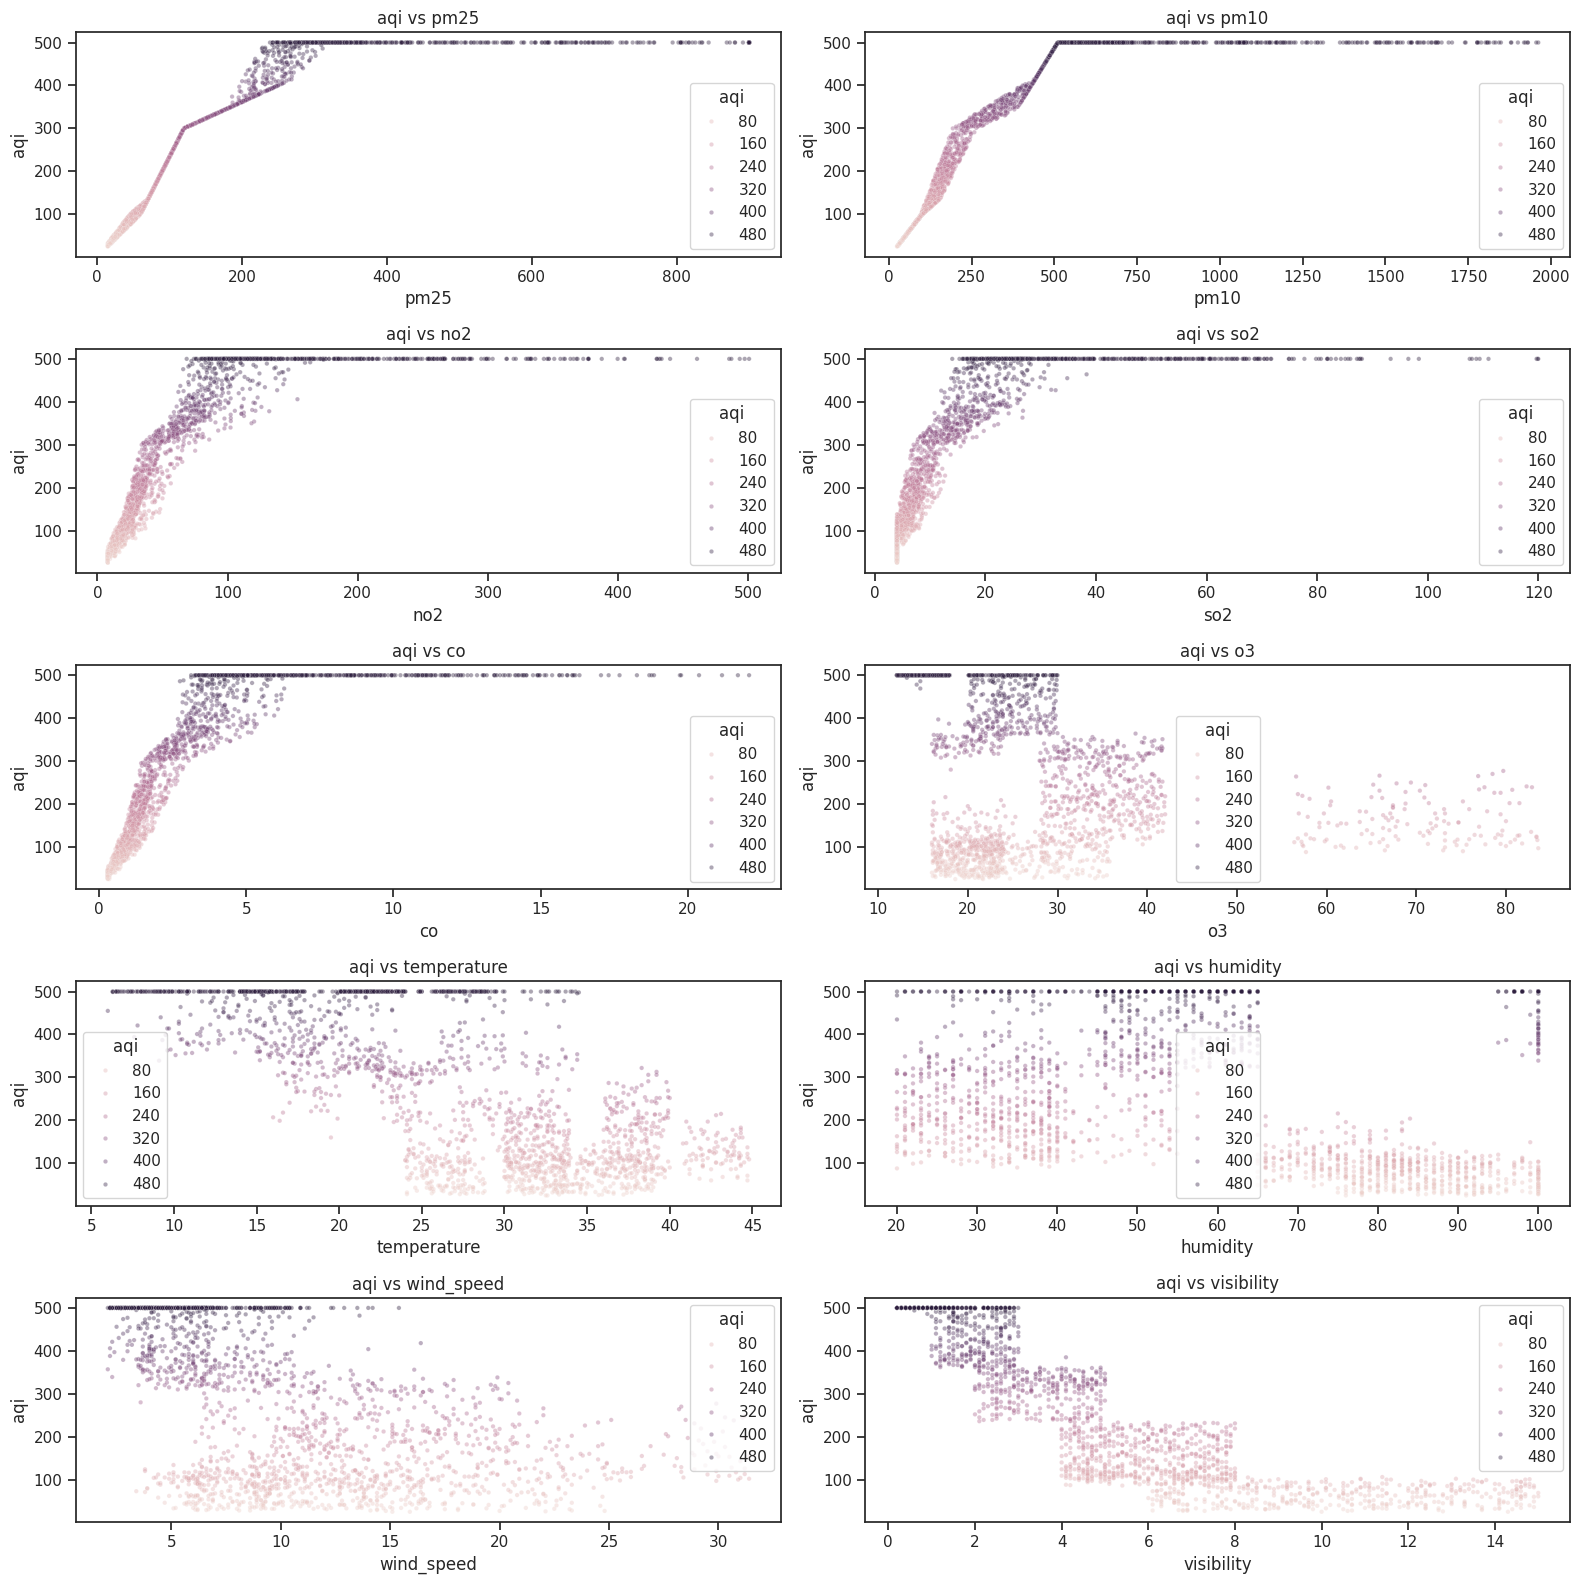

In [55]:
fig, axes = plt.subplots(5,2, figsize=(16,16))
axes = axes.flatten()
cols = ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3', 'temperature', 'humidity', 'wind_speed', 'visibility']
for ax, c in zip(axes, cols):
    sns.scatterplot(
    data=sampled_trimmed_dataset_encoded,
    x=c,
    y="aqi",
    ax=ax,
    s=10,
    alpha=0.4,
    hue="aqi"
)
    ax.set_title(f'aqi vs {c}')
    ax.set_xlabel(c)
    ax.set_ylabel("aqi")
plt.tight_layout()
plt.show()

In [56]:
categorical_feature_dummy_cols = ['is_weekend','day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'season_post_monsoon', 'season_summer',
       'season_winter']
y = sampled_trimmed_dataset_encoded['aqi']
X = sampled_trimmed_dataset_encoded.drop(columns=['aqi'])
X['datetime'] = (X['datetime'].astype(np.int64)//10**9).astype(np.int64)
is_discrete_mask = [True if col in categorical_feature_dummy_cols else False for col in X]

In [57]:
mi_scores = mutual_info_regression(X,y,discrete_features=is_discrete_mask, random_state=34)
mi_results = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

In [58]:
mi_results

pm25                     3.279246
pm10                     3.213920
no2                      1.499685
co                       1.488877
so2                      1.236068
visibility               1.085005
datetime                 1.066773
o3                       0.622998
humidity                 0.614066
temperature              0.581787
season_winter            0.404565
season_summer            0.380379
wind_speed               0.366222
season_post_monsoon      0.096856
latitude                 0.015636
day_of_week_Tuesday      0.008310
day_of_week_Sunday       0.002733
longitude                0.001809
day_of_week_Monday       0.001283
day_of_week_Wednesday    0.000938
is_weekend               0.000000
day_of_week_Thursday     0.000000
day_of_week_Saturday     0.000000
dtype: float64